In [44]:
# Initialization

from qiskit import Aer
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import QFT
import numpy as np

In [55]:
# Helper functions

def get_unirary(qc):
    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend)
    result = job.result()
    return result.get_unitary(qc)

def get_histogram(qc, shots=1000):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=shots)
    result = job.result()
    return result.get_counts()

In [151]:
#swap + no_end_swap_QFT
#which is QFT with right-most bit as 0th bit

def swap_QFT(qc, target_qubits, inverse=False):
    num_qubits = len(target_qubits)
    if inverse:
        qc.append(QFT(num_qubits=num_qubits, do_swaps=False, inverse=True), target_qubits)
        for i in range(num_qubits//2):
            qc.swap(target_qubits[i], target_qubits[num_qubits-1-i])
    else:
        for i in range(num_qubits//2):
            qc.swap(target_qubits[i], target_qubits[num_qubits-1-i])
        qc.append(QFT(num_qubits=num_qubits, do_swaps=False, inverse=False), target_qubits)

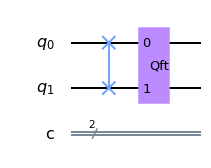

In [159]:
# Test on 2 qubits

num_qubits = 2

qr = QuantumRegister(num_qubits,'q')
cr = ClassicalRegister(num_qubits,'c')
qc = QuantumCircuit(qr, cr)
        
swap_QFT(qc, [0, 1])

qc.draw(output='mpl')

In [160]:
# Unitary associated with 2-qubit QFT

np.round(get_unirary(qc), 2)

array([[ 0.5+0.j ,  0.5-0.j ,  0.5-0.j ,  0.5-0.j ],
       [ 0.5+0.j ,  0. +0.5j, -0.5+0.j , -0. -0.5j],
       [ 0.5+0.j , -0.5+0.j ,  0.5-0.j , -0.5+0.j ],
       [ 0.5+0.j , -0. -0.5j, -0.5+0.j ,  0. +0.5j]])

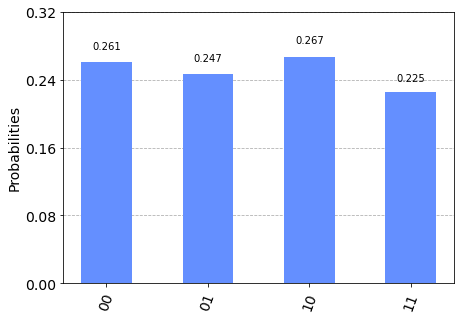

In [162]:
# Histogram of QFT|0>

qc.measure(qr, cr)
plot_histogram(get_histogram(qc))

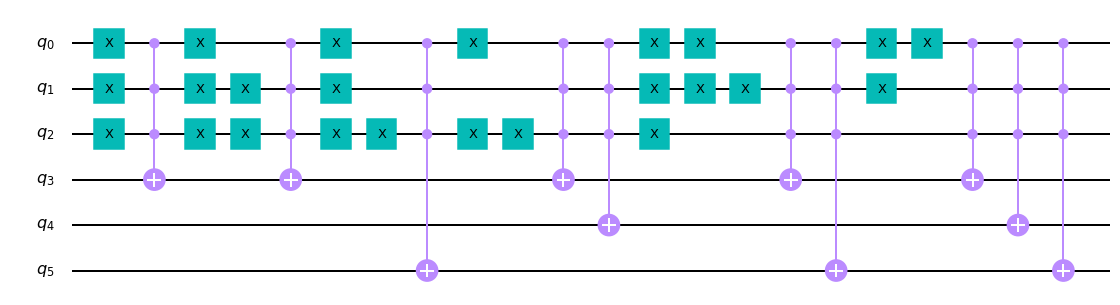

In [163]:
# Unitary of an arbitrary classical binary function f: {0, 1}^n -> {0, 1}^m

def unitary_f(qc, input_qubits, output_qubits, f):
    input_num = len(input_qubits)
    output_num = len(output_qubits)
    
    for x in range(2**input_num):
        
        zeros = []
        xbstr = format(x, f'0{input_num}b')[::-1]
        for i in range(len(xbstr)):
            if xbstr[i] == '0':
                zeros.append(i)
       
        fx = f(x)
        fones = []
        fxbstr = format(fx, f'0{output_num}b')[::-1]
        for j in range(len(fxbstr)):
            if fxbstr[j] == '1':
                fones.append(j)
        
        target_qubits = [output_qubits[j] for j in fones]
        
        for k in zeros:
            qc.x(input_qubits[k])
        for target_qubit in target_qubits:
            qc.mcx(input_qubits, target_qubit)
        for k in zeros:
            qc.x(input_qubits[k])

qc = QuantumCircuit(6)
f = lambda x:(x**x) % 8
unitary_f(qc, [0, 1, 2], [3, 4, 5], f)
qc.draw(output='mpl')

In [166]:
# Exponential of the unitary of an arbitrary classical binary function f: {0, 1}^n -> {0, 1}^m 

def exp_unitary_f(qc, input_qubits, output_qubits, f):
    qc.x(output_qubits)
    qc.barrier()
    swap_QFT(qc, output_qubits)
    qc.barrier()
    unitary_f(qc, input_qubits, output_qubits, f)
    qc.barrier()
    swap_QFT(qc, output_qubits, inverse=True)
    qc.barrier()

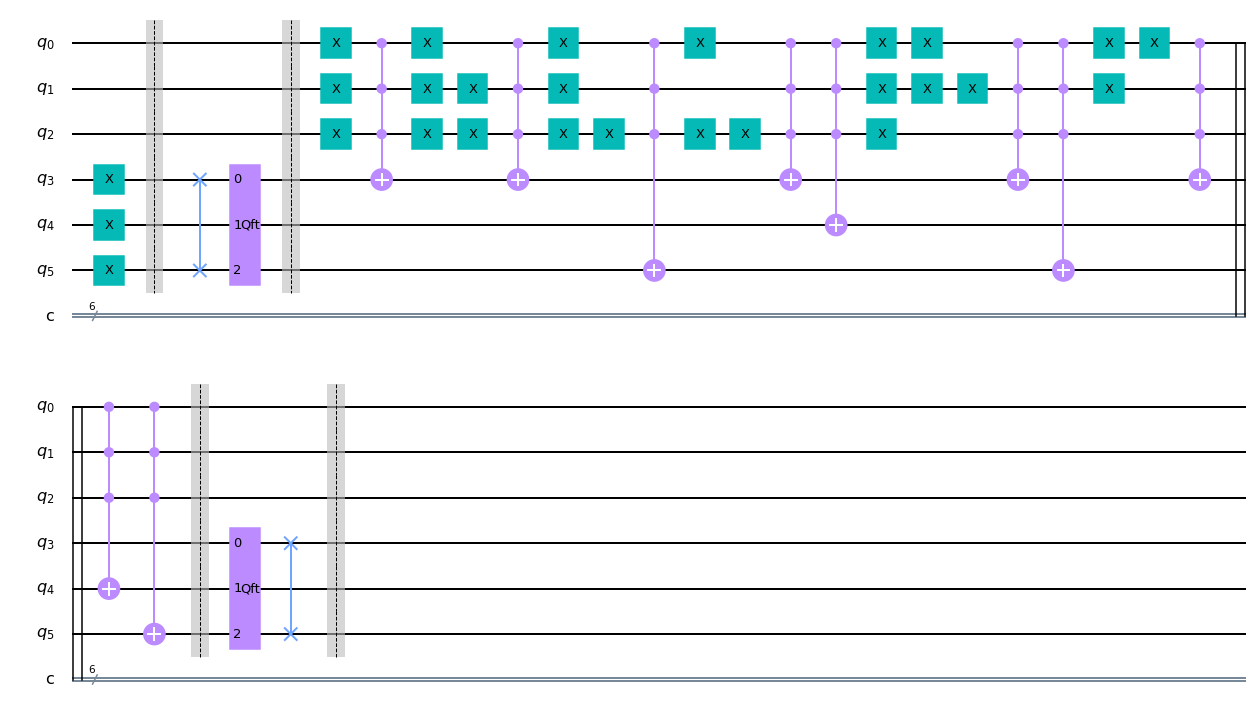

In [167]:
# Test on 3+3 qubits

num_qubits = 6

qr = QuantumRegister(num_qubits,'q')
cr = ClassicalRegister(num_qubits,'c')
qc = QuantumCircuit(qr, cr)
f = lambda x:(x**x) % 8

exp_unitary_f(qc, [0, 1, 2], [3, 4, 5], f)

qc.draw(output='mpl')